# Specifying epitopes

Polyclonal sera contains antibodies that can target multiple distinct epitopes on a viral protein, but we do not know the exact composition of this sera and which epitopes are targeted. At minimum, `Polyclonal` requires a user to specify the number of epitopes prior to fitting. Alternatively, a user may opt to seed initial guesses for the mutation-escape values of key epitope sites.

Here, we’ll use simulated data to show how the number of epitopes and seeding of key sites can affect the performance of `Polyclonal` models. We'll also use this to provide guidance on how to systematically determine the optimal number of epitopes. 

In [1]:
import itertools
import os
import pickle

import altair as alt
import numpy as np
import pandas as pd
import polyclonal

from plotnine import *

First, we read in a simulated “noisy” dataset containing variants measured at three different sera concentrations. The variants in this library were simulated to contain a Poisson-distributed number of mutations, with an average of three mutations per gene.

In [2]:
noisy_data = (
    pd.read_csv("RBD_variants_escape_noisy.csv", na_filter=None)
    .query('library == "avg3muts"')
    .query("concentration in [0.25, 1, 4]")
    .reset_index(drop=True)
)
noisy_data

,library,barcode,concentration,prob_escape,aa_substitutions,IC90
0,avg3muts,AAAACTGCTGAGGAGA,0.25,0.054700,,0.08212
1,avg3muts,AAAAGCAGGCTACTCT,0.25,0.000000,,0.08212
2,avg3muts,AAAAGCTATAGGTGCC,0.25,0.007613,,0.08212
3,avg3muts,AAAAGGTATTAGTGGC,0.25,0.001363,,0.08212
4,avg3muts,AAAAGTGCCTTCGTTA,0.25,0.000000,,0.08212
...,...,...,...,...,...,...
119995,avg3muts,GAGCATGATCGACGAA,1.00,0.000000,Y508V H519I,0.10830
119996,avg3muts,GAGCATGATCGACGAA,4.00,0.000000,Y508V H519I,0.10830
119997,avg3muts,CTTAAAATAGCTGGTC,0.25,0.000000,Y508W,0.08212
119998,avg3muts,CTTAAAATAGCTGGTC,1.00,0.012260,Y508W,0.08212


We'll also read in the "true" mutation-escape values, $\beta_{m,e}$, as a reference for later.

In [3]:
true_mut_escape_df = pd.read_csv("RBD_mut_escape_df.csv").replace(
    "class ", "", regex=True
)
true_mut_escape_df

,epitope,mutation,escape
0,1,N331A,0.000
1,1,N331D,0.000
2,1,N331E,0.000
3,1,N331F,0.000
4,1,N331G,1.701
...,...,...,...
5791,3,T531R,0.000
5792,3,T531S,0.000
5793,3,T531V,0.000
5794,3,T531W,0.000


Additionally, we’ll make a directory for storing our fit models as [pickle](https://docs.python.org/3/library/pickle.html#module-pickle) files, so that we can conveniently load them in the future without having to fit again.

In [4]:
os.makedirs("fit_polyclonal_models", exist_ok=True)

## Specifying epitopes without prior knowledge

First, we'll simulate a case in which we have no prior knowledge about which sites confer antibody escape. Thus, we will only supply guesses for the number of epitopes targeted by the polyclonal sera. We can guess that there are probably at least 2 epitopes targeted by polyclonal sera, so we'll start by specifying 2 epitopes and iteratively fit `Polyclonal` models with increasing number of epitopes.  

In [5]:
n_epitopes = [2, 3, 4]

# store fit models for future lookup
fit_mut_escape = {}

for e in n_epitopes:
    # The key for the fit model
    model_string = f"noisy_[0.25, 1, 4]conc_3muts_{e}epitopes_noinit"

    # If the pickled model exists in the fit_polyclonal_models directory, load it.
    if os.path.exists(f"fit_polyclonal_models/{model_string}.pkl") is True:
        model = pickle.load(open(f"fit_polyclonal_models/{model_string}.pkl", "rb"))
        fit_mut_escape.update({model_string: model})
        print(f"Model with {e} epitopes specified was already fit.")
    else:
        # Else, fit a model and save it to the fit_polyclonal_models directory.
        model = polyclonal.Polyclonal(
            data_to_fit=noisy_data,
            n_epitopes=e,
        )
        opt_res = model.fit(
            logfreq=500,
            reg_escape_weight=0.01,
            reg_uniqueness2_weight=0,
        )
        fit_mut_escape.update({model_string: model})
        pickle.dump(model, open(f"fit_polyclonal_models/{model_string}.pkl", "wb"))

Model with 2 epitopes specified was already fit.
Model with 3 epitopes specified was already fit.
Model with 4 epitopes specified was already fit.


We can correlate the $\beta_{m,e}$ values for each of the epitopes fit by `Polyclonal` to the $\beta_{m,e}$ values for each of the three "true" epitopes. These $\beta_{m,e}$ values represent the extent to which mutations mediate escape from specific epitopes.

In [6]:
plot_data = pd.DataFrame()
for e in n_epitopes:
    model = fit_mut_escape[f"noisy_[0.25, 1, 4]conc_3muts_{e}epitopes_noinit"]

    # get correlation of mutation-escape values between all pairwise combinations of fit vs. true epitopes
    for true_e, fit_e in list(
        itertools.product(
            true_mut_escape_df["epitope"].unique(),
            model.mut_escape_df["epitope"].unique(),
        )
    ):
        df = true_mut_escape_df.query(f'epitope == "{true_e}"').merge(
            (
                model.mut_escape_df.rename(
                    columns={
                        "escape": "predicted escape",
                        "epitope": "predicted epitope",
                    }
                ).query(f'`predicted epitope` == "{fit_e}"')
            ),
            on="mutation",
            validate="one_to_one",
        )

        corr = df["escape"].corr(df["predicted escape"] ** 2)

        plot_data = pd.concat(
            [
                plot_data,
                pd.DataFrame(
                    data={
                        "Number of fit epitopes": [e],
                        "True epitope class": [true_e],
                        "Fit epitope class": [fit_e],
                        "Correlation (R^2)": [corr],
                    }
                ),
            ]
        ).reset_index(drop=True)

In [7]:
alt.Chart(plot_data).mark_rect(
    opacity=0.95,
    stroke="black",
).encode(
    x="Fit epitope class:O",
    y="True epitope class:O",
    color=alt.Color("Correlation (R^2):Q", scale=alt.Scale(scheme="viridis")),
    tooltip=[
        "Fit epitope class:O",
        "True epitope class:O",
        alt.Tooltip("Correlation (R^2)", format=".3f"),
    ],
).properties(
    width=130,
    height=100,
).facet(
    "Number of fit epitopes",
)

/home/tyu2/.local/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.FacetChart(...)

We can also visualize the wildtype activity values, $a_{wt,e}$.

In [8]:
for e in n_epitopes:
    model = fit_mut_escape[f"noisy_[0.25, 1, 4]conc_3muts_{e}epitopes_noinit"]
    print(f"Number of fit epitopes: {e}")
    display(model.activity_wt_barplot())

Number of fit epitopes: 2


alt.Chart(...)

Number of fit epitopes: 3


alt.Chart(...)

Number of fit epitopes: 4


alt.Chart(...)

In the simulation ground truth, there are three epitopes (class 1, 2, and 3). The order of immunodominance from highest to lowest is class 2 > class 3 > class 1.

- The model that specified two epitopes (left heatmap) fit mutation-escape values that strongly correlate with that of the true class 2 and 3 epitopes. This is expected, as the model prioritizes epitopes by their immunodominance and ignores the most subdominant class 1 epitope.

- The model that specified three epitopes (center heatmap) fit mutation-escape values that strongly correlate with that of the true class 1, 2, and 3 epitopes. This is also expected, suggesting that the class 1 epitope, though subdominant, is not redundant. 

- The model that specified four epitopes (right heatmap) fit three epitopes with mutation-escape values that strongly correlate with that of the true class 1, 2, and 3 epitopes. However, the fourth fit epitope did not correlate with any of the true epitopes. This "redundant" epitope also had a strongly negative wildtype activity value, suggesting that antibodies targeting that "epitope" don't make an appreciable contribution to the observed data.

Additionally, we can look at the correlation between “true” and predicted IC90’s for each of the fit models. To do this, we’ll predict the IC90’s of variants in a separate library with a different (higher) mutation rate. We therefore read in the “exact” simulated data from a library containing variants with an average of four mutations per gene.

In [9]:
exact_data = (
    pd.read_csv("RBD_variants_escape_exact.csv", na_filter=None)
    .query('library == "avg4muts"')
    .query("concentration in [1]")
    .reset_index(drop=True)
)

We’ll make the comparison on a log scale, and clip IC90s at values >50 as that is likely to be way outside the dynamic range given the concentrations used.

In [10]:
ic90_corrs = pd.DataFrame()
ic90_data = pd.DataFrame()

max_ic90 = 50
for e in n_epitopes:
    model = fit_mut_escape[f"noisy_[0.25, 1, 4]conc_3muts_{e}epitopes_noinit"]

    ic90s = (
        exact_data[["aa_substitutions", "IC90"]]
        .assign(IC90=lambda x: x["IC90"].clip(upper=max_ic90))
        .drop_duplicates()
    )
    ic90s = model.filter_variants_by_seen_muts(ic90s)
    ic90s = model.icXX(ic90s, x=0.9, col="predicted_IC90", max_c=max_ic90)

    ic90s = ic90s.assign(
        log_IC90=lambda x: np.log10(x["IC90"]),
        predicted_log_IC90=lambda x: np.log10(x["predicted_IC90"]),
    )

    corr = ic90s["log_IC90"].corr(ic90s["predicted_log_IC90"]) ** 2

    ic90_corrs = pd.concat(
        [
            ic90_corrs,
            pd.DataFrame(
                {
                    "number_fit_epitopes": [e],
                    "Correlation (R^2)": "{:.3f}".format(corr),
                }
            ),
        ]
    ).reset_index(drop=True)

    ic90_data = pd.concat(
        [
            ic90_data,
            (
                ic90s[["log_IC90", "predicted_log_IC90"]].assign(
                    **{"number_fit_epitopes": e}
                )
            ),
        ]
    ).reset_index(drop=True)

In [11]:
ic90_corrs

,number_fit_epitopes,Correlation (R^2)
0,2,0.798
1,3,0.947
2,4,0.900


/home/tyu2/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


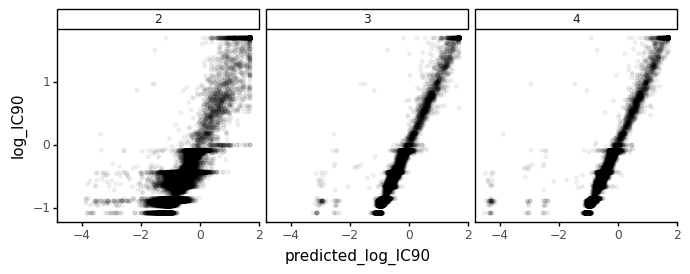

<ggplot: (8752897379118)>

In [12]:
(
    ggplot(ic90_data, aes(x="predicted_log_IC90", y="log_IC90"))
    + geom_point(alpha=0.05, size=1)
    + facet_wrap("number_fit_epitopes")
    + theme_classic()
    + theme(figure_size=(8, 2.5))
)

Although the IC90 prediction appears excellent regardless of the number of fit epitopes, adding the 3rd epitope does lead to a small improvement in the prediction.

## Specifying epitopes with prior knowledge

Next, we'll explore the consequences of cases where we think we have prior knowledge of some sites that confer antibody escape, but do not know the exact number of epitopes that are targeted. We can start by "seeding" initial guesses for 2 epitopes and iteratively fitting `Polyclonal` models with more initial guesses.

- **Case 1**: We guess from prior knowledge that site 484 and site 444 are key epitope sites, so we seed them with large mutation-escape values.

- **Case 2**: Building on Case 1, we seed a 3rd key site, 417, which is often considered to be in the most subdominant class 1 epitope.

- **Case 3**: Building on Case 2, we add a 4th key site, 386, that is **not** actually in an epitope that is targeted by polyclonal antibodies.

- **Case 4**: Building on Case 2, we add a 4th key site that is already located in an epitope that we've specified. Specifically, we'll seed it with site 460, which is in the class 1 epitope along with site 417.

In [13]:
model_params = {
    ### Case 1
    "noisy_[0.25, 1, 4]conc_3muts_2epitopes_seed484_444": [
        # wildtype activity guesses
        [("1", 2.0), ("2", 1.0)],
        # key epitope site guesses
        [
            ("1", 484, 10.0),
            ("2", 444, 10.0),
        ],
    ],
    ### Case 2
    "noisy_[0.25, 1, 4]conc_3muts_3epitopes_seed417_484_444": [
        # wildtype activity guesses
        [
            ("1", 1.0),
            ("2", 3.0),
            ("3", 2.0),
        ],
        # key epitope site guesses
        [
            ("1", 417, 10.0),
            ("2", 484, 10.0),
            ("3", 444, 10.0),
        ],
    ],
    ### Case 3
    "noisy_[0.25, 1, 4]conc_3muts_4epitopes_seed417_484_444_386": [
        # wildtype activity guesses
        [
            ("1", 2.0),
            ("2", 4.0),
            ("3", 3.0),
            ("4", 1.0),
        ],
        # key epitope site guesses
        [
            ("1", 417, 10.0),
            ("2", 484, 10.0),
            ("3", 444, 10.0),
            ("4", 386, 10.0),
        ],
    ],
    ### Case 4
    "noisy_[0.25, 1, 4]conc_3muts_4epitopes_seed417_484_444_460": [
        # wildtype activity guesses
        [
            ("1", 2.0),
            ("2", 4.0),
            ("3", 3.0),
            ("4", 1.0),
        ],
        # key epitope site guesses
        [
            ("1", 417, 10.0),
            ("2", 484, 10.0),
            ("3", 444, 10.0),
            ("4", 460, 10.0),
        ],
    ],
}

Fit `Polyclonal` models for each of the cases above.

In [14]:
for model_string in model_params.keys():
    # If the pickled model exists in the fit_polyclonal_models directory, load it.
    if os.path.exists(f"fit_polyclonal_models/{model_string}.pkl") is True:
        model = pickle.load(open(f"fit_polyclonal_models/{model_string}.pkl", "rb"))
        fit_mut_escape.update({model_string: model})
        print(f"{model_string} was already fit.")
    else:
        # Else, fit a model and save it to the fit_polyclonal_models directory.
        model = polyclonal.Polyclonal(
            data_to_fit=noisy_data,
            activity_wt_df=pd.DataFrame.from_records(
                model_params[model_string][0],
                columns=["epitope", "activity"],
            ),
            site_escape_df=pd.DataFrame.from_records(
                model_params[model_string][1],
                columns=["epitope", "site", "escape"],
            ),
            data_mut_escape_overlap="fill_to_data",
        )

        opt_res = model.fit(
            logfreq=500,
            reg_escape_weight=0.01,
            reg_uniqueness2_weight=0,
        )
        fit_mut_escape.update({model_string: model})
        pickle.dump(model, open(f"fit_polyclonal_models/{model_string}.pkl", "wb"))

noisy_[0.25, 1, 4]conc_3muts_2epitopes_seed484_444 was already fit.
noisy_[0.25, 1, 4]conc_3muts_3epitopes_seed417_484_444 was already fit.
noisy_[0.25, 1, 4]conc_3muts_4epitopes_seed417_484_444_386 was already fit.
noisy_[0.25, 1, 4]conc_3muts_4epitopes_seed417_484_444_460 was already fit.


Like before, we can correlate the $\beta_{m,e}$ values for each of the epitopes fit by these `Polyclonal` models to the $\beta_{m,e}$ values for each of the three "true" epitopes.

In [15]:
plot_data = pd.DataFrame()
for st in [
    "2epitopes_seed484_444",
    "3epitopes_seed417_484_444",
    "4epitopes_seed417_484_444_386",
    "4epitopes_seed417_484_444_460",
]:
    model = fit_mut_escape[f"noisy_[0.25, 1, 4]conc_3muts_{st}"]
    for true_e, fit_e in list(
        itertools.product(
            true_mut_escape_df["epitope"].unique(),
            model.mut_escape_df["epitope"].unique(),
        )
    ):
        df = true_mut_escape_df.query(f'epitope == "{true_e}"').merge(
            (
                model.mut_escape_df.rename(
                    columns={
                        "escape": "predicted escape",
                        "epitope": "predicted epitope",
                    }
                ).query(f'`predicted epitope` == "{fit_e}"')
            ),
            on="mutation",
            validate="one_to_one",
        )

        corr = df["escape"].corr(df["predicted escape"] ** 2)

        plot_data = pd.concat(
            [
                plot_data,
                pd.DataFrame(
                    data={
                        "Epitope seeding": [st],
                        "True epitope class": [true_e],
                        "Fit epitope class": [fit_e],
                        "Correlation (R^2)": [corr],
                    }
                ),
            ]
        ).reset_index(drop=True)

In [16]:
alt.Chart(plot_data).mark_rect(
    opacity=0.95,
    stroke="black",
).encode(
    x="Fit epitope class:O",
    y="True epitope class:O",
    color=alt.Color("Correlation (R^2):Q", scale=alt.Scale(scheme="viridis")),
    tooltip=[
        "Fit epitope class:O",
        "True epitope class:O",
        alt.Tooltip("Correlation (R^2)", format=".3f"),
    ],
).properties(
    width=130,
    height=100,
).facet(
    "Epitope seeding",
    columns=2,
)

/home/tyu2/.local/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


alt.FacetChart(...)

We can also visualize the wildtype activity values, $a_{wt,e}$.

In [17]:
for st in [
    "2epitopes_seed484_444",
    "3epitopes_seed417_484_444",
    "4epitopes_seed417_484_444_386",
    "4epitopes_seed417_484_444_460",
]:
    model = fit_mut_escape[f"noisy_[0.25, 1, 4]conc_3muts_{st}"]
    print(f"Epitope seeding: {st}")
    display(model.activity_wt_barplot())

Epitope seeding: 2epitopes_seed484_444


alt.Chart(...)

Epitope seeding: 3epitopes_seed417_484_444


alt.Chart(...)

Epitope seeding: 4epitopes_seed417_484_444_386


alt.Chart(...)

Epitope seeding: 4epitopes_seed417_484_444_460


alt.Chart(...)

These results look similar to the ones obtained without seeding sites above. But importantly, we can see that the models are not negatively impacted by seeding sites that are not within a targeted epitope or within the same epitope as an already seeded  site. Although not seen on this simulated dataset, keep in mind that seeding sites could be helpful and lead to better results if the library mutation rate is low.

Additionally, we can look at the correlation between “true” and predicted IC90’s for each of these fit models.

In [18]:
ic90_corrs = pd.DataFrame()
ic90_data = pd.DataFrame()

max_ic90 = 50
for st in [
    "2epitopes_seed484_444",
    "3epitopes_seed417_484_444",
    "4epitopes_seed417_484_444_386",
    "4epitopes_seed417_484_444_460",
]:
    model = fit_mut_escape[f"noisy_[0.25, 1, 4]conc_3muts_{st}"]

    ic90s = (
        exact_data[["aa_substitutions", "IC90"]]
        .assign(IC90=lambda x: x["IC90"].clip(upper=max_ic90))
        .drop_duplicates()
    )
    ic90s = model.filter_variants_by_seen_muts(ic90s)
    ic90s = model.icXX(ic90s, x=0.9, col="predicted_IC90", max_c=max_ic90)

    ic90s = ic90s.assign(
        log_IC90=lambda x: np.log10(x["IC90"]),
        predicted_log_IC90=lambda x: np.log10(x["predicted_IC90"]),
    )

    corr = ic90s["log_IC90"].corr(ic90s["predicted_log_IC90"]) ** 2

    ic90_corrs = pd.concat(
        [
            ic90_corrs,
            pd.DataFrame(
                {
                    "epitope_seeding": [st],
                    "Correlation (R^2)": "{:.3f}".format(corr),
                }
            ),
        ]
    ).reset_index(drop=True)

    ic90_data = pd.concat(
        [
            ic90_data,
            (
                ic90s[["log_IC90", "predicted_log_IC90"]].assign(
                    **{"epitope_seeding": st}
                )
            ),
        ]
    ).reset_index(drop=True)

In [19]:
ic90_corrs

,epitope_seeding,Correlation (R^2)
0,2epitopes_seed484_444,0.799
1,3epitopes_seed417_484_444,0.965
2,4epitopes_seed417_484_444_386,0.966
3,4epitopes_seed417_484_444_460,0.899


/home/tyu2/.local/lib/python3.8/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


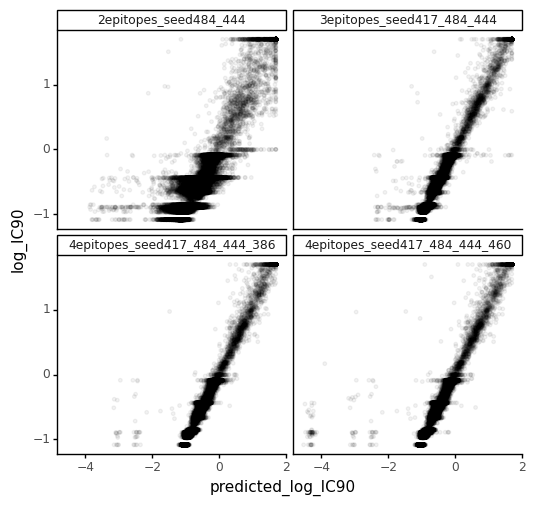

In [20]:
_ = (
    ggplot(ic90_data, aes(x="predicted_log_IC90", y="log_IC90"))
    + geom_point(alpha=0.05, size=1)
    + facet_wrap("epitope_seeding", ncol=2)
    + theme_classic()
    + theme(figure_size=(6, 5.5))
).draw()

## Summary

These simulation experiments provide a general guideline for specifying epitopes. When fitting `Polyclonal` models, one can start with 2 epitopes and iteratively fit models with increasing number of epitopes. At some point, the newly seeded $N$-th epitope will become redundant, as evidenced by a strongly negative wildtype activity value, $a_{wt,e}$. This is indication to the user that the previous fit model, containing $N - 1$ epitopes, is the one that best captures the data and polyclonal mix.